# Setup

In [1]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from global_land_mask import globe
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

# Define Constants
prctl_bins = np.arange(0,105,5) # bottom edge of percentile bins
prctl_binmids = (prctl_bins[:-1]+prctl_bins[1:])/2 # center of percentile bins

# Plotting Utils

In [2]:
plt.rcParams.update({
    'font.size': 22,        # Global font size
    'axes.labelsize': 22,   # Font size for axis labels
    'axes.titlesize': 24,   # Font size for subplot titles
    'legend.fontsize': 20,  # Font size for legend
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20   # Font size for y-axis tick labels
})

## SST plotting

In [3]:
def create_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T, vmin=16,vmax=32) 
    axes[0].set_title("Average SST in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('K')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, vmin=-1,vmax=1, cmap='RdBu_r')
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SST Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label('K')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, vmin=-1,vmax=1, cmap='RdBu_r')
    axes[2].set_title("SST Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SST# - SSTb", linewidth=4)
    twin_ax2.hlines(np.nanmean(ds.sharp - ds.flat), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label('K')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SWCRE plotting

In [4]:
def create_swcre_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T) #, vmin=-120, vmax=0)
    axes[0].set_title("Average SWCRE in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, cmap='RdBu_r', vmax=10, vmin=-10)
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SWCRE Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, cmap='RdBu_r', vmax=10, vmin=-10)
    axes[2].set_title("SWCRE Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SWCRE# - SWCREb", linewidth=4)
    twin_ax2.hlines(np.nanmean(-(ds.sharp - ds.flat)), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label(r'$Wm^{-2}$')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SWCRE sorted on SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_SWCRE_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCRE_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SST Trend plotting

In [5]:
def sanity_rolling_trend(window: int, sharp: xr.DataArray, flat: xr.DataArray, trend: xr.DataArray, raw: xr.DataArray, model: str) -> None:
    # Create matplotlib 2 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 20))
    ax1_twin = ax1.twinx()
    ntime = sharp.shape[0]
    time = np.arange(ntime)

    # Add grid lines to all subplots
    ax1.grid(); ax2.grid(); ax3.grid()

    # Plot time vs trend on ax1
    ax1.plot(time, raw, color='black', label=r"SST$d$", linewidth=4)

    # Plot sharp on ax1_twin
    ax1_twin.plot(time, flat, color='purple', label=r"SST$b$", linewidth=4)
    ax1_twin.plot(time, sharp, color='maroon', label=r"SST#", linewidth=4)
    ax1.set_ylabel(r"SST$d$ (K)"); ax1_twin.set_ylabel(r"SST# and SST$b$ (K)")
    ax1.set_title(r"SST$d$ (SST# - SST$b$)", loc="left", fontweight="bold")
    # Set x tick labels starting in 1850 every 5 years 
    ax1.set_xticklabels(np.arange(1850, 1850+int(ntime/12), 10))
    ax1.set_xticks(time[::12*10])
    # Add a black horizontal line at 0 
    ax1.hlines(0, xmin=time[0], xmax=time[-1], color="black", linestyle="--", linewidth=4)
    # Retrieve the handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    # Concatenate the handles and labels from both axes
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Create the legend using the concatenated handles and labels
    ax1.legend(handles, labels)
    
    # Set ylim of twin_ax1 to be 20% larger than the range of the data
    ax1_twin.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)
    ax1.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)

    # Plot ntime vs trend on ax2
    # trend_time = np.arange(int(window/2), ntime - int(window/2))
    ntrend = trend.shape[0]
    ax2.plot(np.arange(ntrend), trend, color='black', label="trend", linewidth=4)
    yrs_window = window/(12*2) # half the years of the length of the window
    xticks = np.arange(0, ntrend, 10)
    xticklabels = np.arange(1850 + yrs_window, 1850 + yrs_window + ntrend, 10) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    ax2.set_xlim(0, ntrend)

    ax2.set_title("SST Trend (K/30yr)", loc="left", fontweight="bold")
    ax2.set_ylabel("SST Trend (K/30yr)"); ax2.set_xlabel("Time")
    ax2.hlines(0, xmin=0, xmax=ntrend, color="black", linestyle="--", linewidth=4)

    hist = sns.histplot(trend, ax=ax3, kde=True, stat="density", linewidth=0)
    ax3.set_title(r"SST$d$ Trend (K/30yr)", loc="left", fontweight="bold")
    ax3.set_title(f"mean: {np.mean(trend):.2f}, variance: {np.var(trend):.2f}", loc="right", fontweight="bold")
    # Add a vertical line at the mean of the trend and the variance and have the ymin and ymax be the max of the histogram
    ax3.vlines(np.mean(trend), ymin=0, ymax=np.max(hist.get_lines()[0].get_data()[1]), color="black", linestyle="--", linewidth=4)
    fig.suptitle(model, fontsize=30, fontweight="bold", y=0.95)

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_trend.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_trend.png", bbox_inches='tight')


## SWCF plotting

In [6]:
def plot_swcf(swcf: xr.DataArray, model: str = ""):
    """Plot the SWCF

    Args:
        swcf (xr.DataArray): SWCF
    """
    fig, ax = plt.subplots(1,1, figsize=(5,3))

    ax.plot(swcf.bins, swcf.values, label=model, linewidth=4)
    ax.legend()
    ax.set_title("SWCF", loc="left", fontweight="bold")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(r"SWCF [$Wm^{-2}K^{-1}$]")
    ax.set_xlim(0, 100)
    ax.grid()
    ax.axhline(y=0, color="black", linestyle="--")
    # Save figure
    plt.savefig(f"figures/{model}_SWCF.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCF.png", bbox_inches='tight')

# plot_swcf(swcf, model="CESM2_test")

# SST Sharp Utils

In [7]:
"""
Library to compute weighted quantiles, including the weighted median, of
numpy arrays.

https://github.com/nudomarinero/wquantiles
"""
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


# def get_percentiles(data,wts,bins):
#     # wrapper for previous functions
#     quantiles = bins/100
#     return np.quantile(data, quantiles)

def get_percentiles(data,wts,bins):
    # wrapper for previous functions
    quantiles = bins/100
    newbins=[]
    # if len(np.where(np.isnan(data))[0]) > 0:
        # raise Exception

    # return np.quantile(data, quantiles)
    for q in quantiles:
        newbins.append(quantile_1D(data, wts, q))
    return newbins

# Testing
# bins = get_percentiles(list(np.random.rand((100))) + list([np.nan, np.nan, np.nan]), np.ones(103), bins=np.arange(0, 110, 10))
# bins = get_percentiles(np.random.rand((100)), np.ones(100), bins=np.arange(0, 110, 10))
# bins

## SST Sharp Sorting

In [10]:
def do_SSTsharp_sorting(da: xr.DataArray, prctl_bins: np.ndarray, prctl_binmids: np.ndarray, weights: np.ndarray) -> xr.Dataset:
    """The goal of this function is to calculate SSTsharp as defined in Fueglistaler (2019)

        Observational evidence for two modes of coupling between sea surface temperatures, 
        tropospheric temperature profile, and shortwave cloud radiative effect in the tropics. 
        Geophysical Research Letters, 46, 9890–9898. https://doi.org/10.1029/2019GL083990

    Args:
        ds (xr.DataArray): _description_
        nbins (int, optional): _description_. Defaults to 20.

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average temperature in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average temperature in each percentile bin minus the monthly climatology
            sortIdxs (xr.DataArray)[time, lon]: Indexes of the sorted data that can be used to sort other dataX (e.g. swcre, rsut, rsutcs) using dataY (e.g. SST)
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SST at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 

    """
    ntime, nlat, nlon = da.shape
    nbins = len(prctl_bins)

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))
    sortIdxs = np.zeros((ntime,nlon*nlat))
    not_nans = np.zeros((ntime,nlon*nlat))
    not_nans.fill(np.nan)
    sortIdxs.fill(np.nan)

    for i in range(ntime):
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i,:,:].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)

        # Remove nans
        v = np.where(~np.isnan(da_slice))[0] 
        not_nans[i,:len(v)] = v
        wts_slice = wts_slice[v]
        da_slice = da_slice[v]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Calculate percentiles (these are the values separating the quantiles)
        bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        inds = np.digitize(da_slice, bins)
        sortIdxs[i,:len(da_slice)] = inds
        # print("sortIdxs : ", inds.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    # for m in range(12):
        # binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    binanom[:,:] = binavg[:,:] - np.nanmean(binavg[:, :], 0)
    
    # Time slice SST Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]
    
    # Calculate SSTsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SSTflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'sortIdxs': (('time','idx'), sortIdxs), 
        'not_nans': (('time','idx'), not_nans), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids.data,
            'idx': np.arange(nlat*nlon),
        }
    ) 
    
    return ds


## SWCRE Sorting

In [11]:
def apply_SSTsharp_to_SWCRE(da: xr.DataArray, prctl_bins: np.ndarray, ds_sharp: xr.Dataset, weights: np.ndarray, model: str) -> xr.Dataset:
    """Apply SSTsharp sorting to SWCRE

    Args:
        da (xr.DataArray): swcre raw monthly data
        prctl_bins (np.ndarray): percentiles to use for sorting from ds_sharp
        ds_sharp (xr.Dataset): SST sharp package
        model (str): name of model

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin minus the monthly climatology
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SWCRE at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 
    """
    ntime, _, _ = da.shape
    nbins = len(prctl_bins)
    
    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))

    for i in range(ntime):
        # Get current time slice
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i, :, :].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)
       
        # Remove values where corresponding SST data is nan
        sst_non_nans = ds_sharp["not_nans"].isel(time=i).values
        sst_non_nans = np.array(sst_non_nans[~np.isnan(sst_non_nans)], dtype=int)
        da_slice = da_slice[sst_non_nans]
        wts_slice = wts_slice[sst_non_nans]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Remove filler nans from sorted inds
        inds = ds_sharp["sortIdxs"].isel(time=i).values
        inds = inds[np.where(~np.isnan(inds))] 
        # print("sortIdxs shape: ", inds.shape)

        # Remove nans from SWCRE 
        nanMask = np.where(~np.isnan(da_slice))[0]
        wts_slice = wts_slice[nanMask]
        da_slice = da_slice[nanMask]
        inds = np.array(inds[nanMask], dtype=int)
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        # Calculate percentiles (these are the values separating the quantiles)
        # bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        # inds = np.digitize(da_slice, bins)

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom
        
        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    # for m in range(12):
        # binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    binanom[:,:] = binavg[:,:] - np.nanmean(binavg[:, :], 0)
    
    # Time slice SWCRE Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]

    # Calculate SWCREsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SWCREflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids,
        }
    ) 
    
    return ds



## Calculate SST Rolling Trend

In [18]:

def calculate_rolling_trend(data: xr.Dataset, model: str = "", window: int = 12*30, step: int = 12) -> xr.Dataset:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.Dataset): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """

    # Calculate SSTd = SSTsharp (warm) - SSTflat (cold)
    SSTd = data["sharp"] - data["flat"]
    ntime = SSTd.shape[0]

    SSTd_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/step))))
    SSTd_trend.fill(np.nan)

    # Calculate rolling trend of SSTd
    time_idx = xr.DataArray(np.arange(window), dims=("time"))
    for j, i in enumerate(range(0, ntime - window, step)):
        slice_SSTd = SSTd.isel(time=slice(i, int(i+window)))
        SSTd_trend[j] = xscore.linslope(time_idx, slice_SSTd, dim='time', skipna=True).values
    
    # Convert SSTd trend and SSTd to xr.DataArray
    SSTd_trend = xr.DataArray(SSTd_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    # Convert SSTd to xr.DataArray
    SSTd = xr.DataArray(SSTd, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    # Combine SSTd and SSTd_trend into xr.Dataset
    ds = xr.Dataset({"SSTd": SSTd, "SSTd_trend": SSTd_trend})
    # Sanity plot of SSTd and SSTd_trend
    sanity_rolling_trend(window=window, sharp=data["sharp"], flat=data["flat"], trend=SSTd_trend*window, raw=SSTd, model=model) 

    # Return SSTd and SSTd_trend
    return ds

# calculate_rolling_trend(ds["CESM2"], model="CESM2_test", window=12, step=1)

## Calculate SWCF

In [13]:
def calculate_swcf_percentiles(SSTsharp: xr.Dataset, SWCREsharp: xr.Dataset) -> xr.Dataset:
    sst_anoms = SSTsharp["binanom_bar"]
    swcre_anoms = SWCREsharp["binanom_bar"]
    swcf = xscore.linslope(sst_anoms, swcre_anoms, dim='time', skipna=True)
    return swcf

# swcf = calculate_swcf_percentiles(SSTsharp=ds["CESM2"], SWCREsharp=swcre)
# swcf

# Process all models

In [14]:
# Load cmip6 SST data
tos = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
tos = tos.bounds.add_bounds("X")
tos = tos.bounds.add_bounds("Y")
tos = xc.swap_lon_axis(tos, to=(-180, 180))

# Load cmip6 swcre data
swcre = xr.open_dataset("data/swcre_cmip6_monthly_1850-2000.nc")
swcre = swcre.bounds.add_bounds("X")
swcre = swcre.bounds.add_bounds("Y")
swcre = xc.swap_lon_axis(swcre, to=(-180, 180))

# Set land to NaN
lon_grid,lat_grid = np.meshgrid(tos.lon,tos.lat)
globe_land_mask = globe.is_land(lat_grid,lon_grid)
globe_land_mask_nd = np.tile(globe_land_mask,(tos["tos"].shape[1],1,1))
# plt.contourf(tos.lon, tos.lat, globe_land_mask_nd[0]) # Sanity check plot
tos_no_land = xr.where(globe_land_mask_nd==True,np.nan,tos["tos"]) 
swcre_no_land = xr.where(globe_land_mask_nd==True,np.nan,swcre["swcre"]) 

# Get Area Weights:
wt = tos.spatial.get_weights(axis=["Y", "X"])
AW = (wt/wt.sum()) # summing this over lat and lon = 1
_, area_wts = xr.broadcast(tos.time,AW)
weights = xr.where(globe_land_mask_nd==True,0,area_wts)    
# plt.contourf(tos.lon, tos.lat, weights[0]); plt.colorbar() # Sanity check plot

# FOCUS ON TROPICS FOR SST SHARP CALCULATIONS
# pacific = (list(np.arange(-180, -110)) + list(np.arange(110, 180)))
# tos_no_land = tos_no_land.sel(lon=pacific, method="nearest")
# swcre_no_land = swcre_no_land.sel(lon=pacific, method="nearest")

tos_tropics = tos_no_land.sel(lat=slice(-30,30))
swcre_tropics = swcre_no_land.sel(lat=slice(-30,30))
weights_tropics = weights.sel(lat=slice(-30,30))

# Replace 0s with nans: for some reason, swcre has 0 in many places -> this may be physical (no clouds), but lets just see what happens when altering
# swcre_tropics = xr.where(swcre_tropics == 0, np.nan, swcre_tropics)

# One-year low-pass filter 
swcre_tropics = swcre_tropics.resample(time="Y").mean()
tos_tropics = tos_tropics.resample(time="Y").mean()

swcre_tropics.load()
tos_tropics.load()

print(tos_tropics.shape)
print(swcre_tropics.shape)


(54, 150, 24, 144)
(54, 150, 24, 144)


In [91]:
print(np.nanmin(tos_tropics))
print(np.nanmax(tos_tropics))
print(np.nanmin(swcre_tropics))
print(np.nanmax(swcre_tropics))

0.0
37.467197
-234.94061
4.2149506


<Axes: ylabel='Count'>

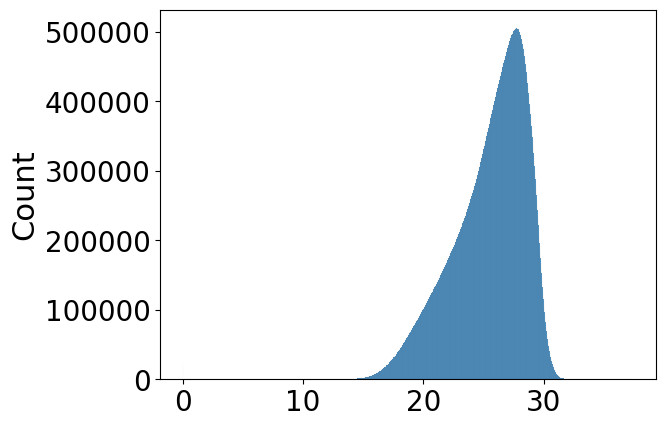

In [96]:
sns.histplot(tos_tropics.to_numpy().flatten())

Is it an issue that SWCRE has so many 0s or is this physical (0 == no clouds).

<Axes: ylabel='Count'>

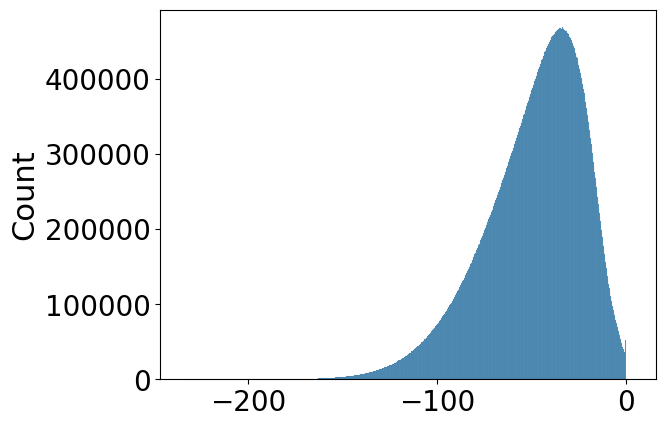

In [182]:
a = swcre_tropics.to_numpy().flatten()
a = a[np.where(~np.isnan(a))]
sns.histplot(a)

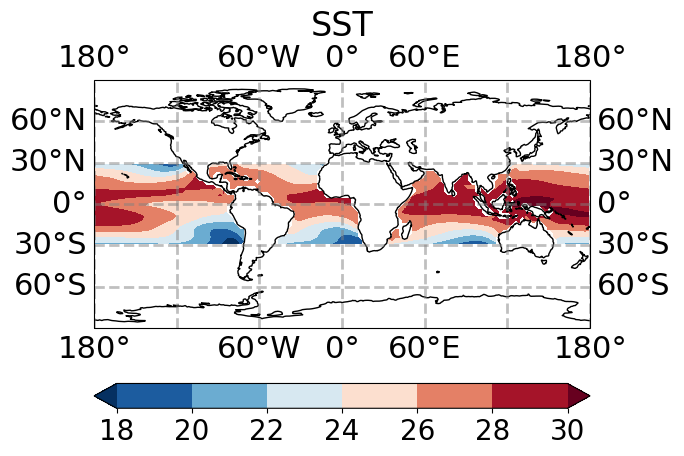

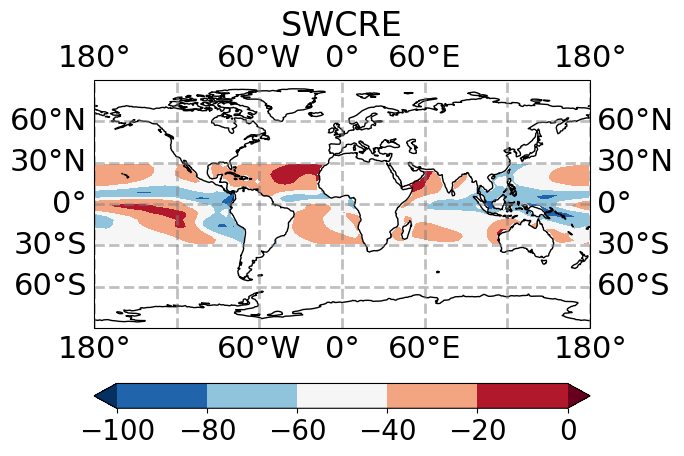

In [94]:
def global_plot(data, lon, lat, cmap, levels, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    im = ax1.contourf(
        lon, lat, data, levels=levels, extend="both", 
        transform=ccrs.PlateCarree(), cmap=cmap
    )
    # Set the extent to 30S - 30N
    ax1.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    # Add a horizontal colorbar
    cbar = plt.colorbar(im, orientation='horizontal')
    ax1.set_title(title)
    plt.show()

global_plot(tos_tropics.sel(model="CESM2").mean(["time"]), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SST", levels=8) #np.arange(16, 34, 2))
global_plot(swcre_tropics.sel(model="CESM2").mean(["time"]), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SWCRE", levels=np.arange(-100, 20, 20)) #np.arange(-120, 45, 5))

In [14]:
swcf = xr.open_dataarray("data/swcf_cmip6_monthly_1850-2000.nc", chunks="auto").sel(model="CESM2").sel(lat=slice(-30, 30)).to_numpy().flatten()
tos = xr.open_dataarray("data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto").sel(model="CESM2").mean(["time"]).sel(lat=slice(-30, 30)).to_numpy().flatten()

Text(0, 0.5, 'Tropical SWCF')

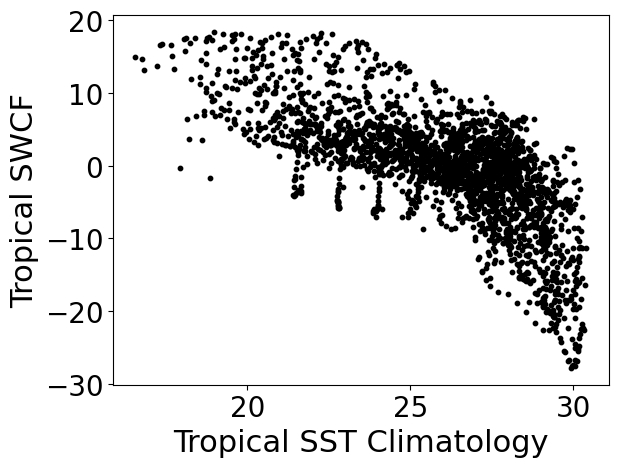

In [19]:
plt.scatter(tos, swcf, s=10, color="black"); plt.xlabel("Tropical SST Climatology"); plt.ylabel("Tropical SWCF")

## Process SST data

Calculating SST sharpness for E3SM-1-1


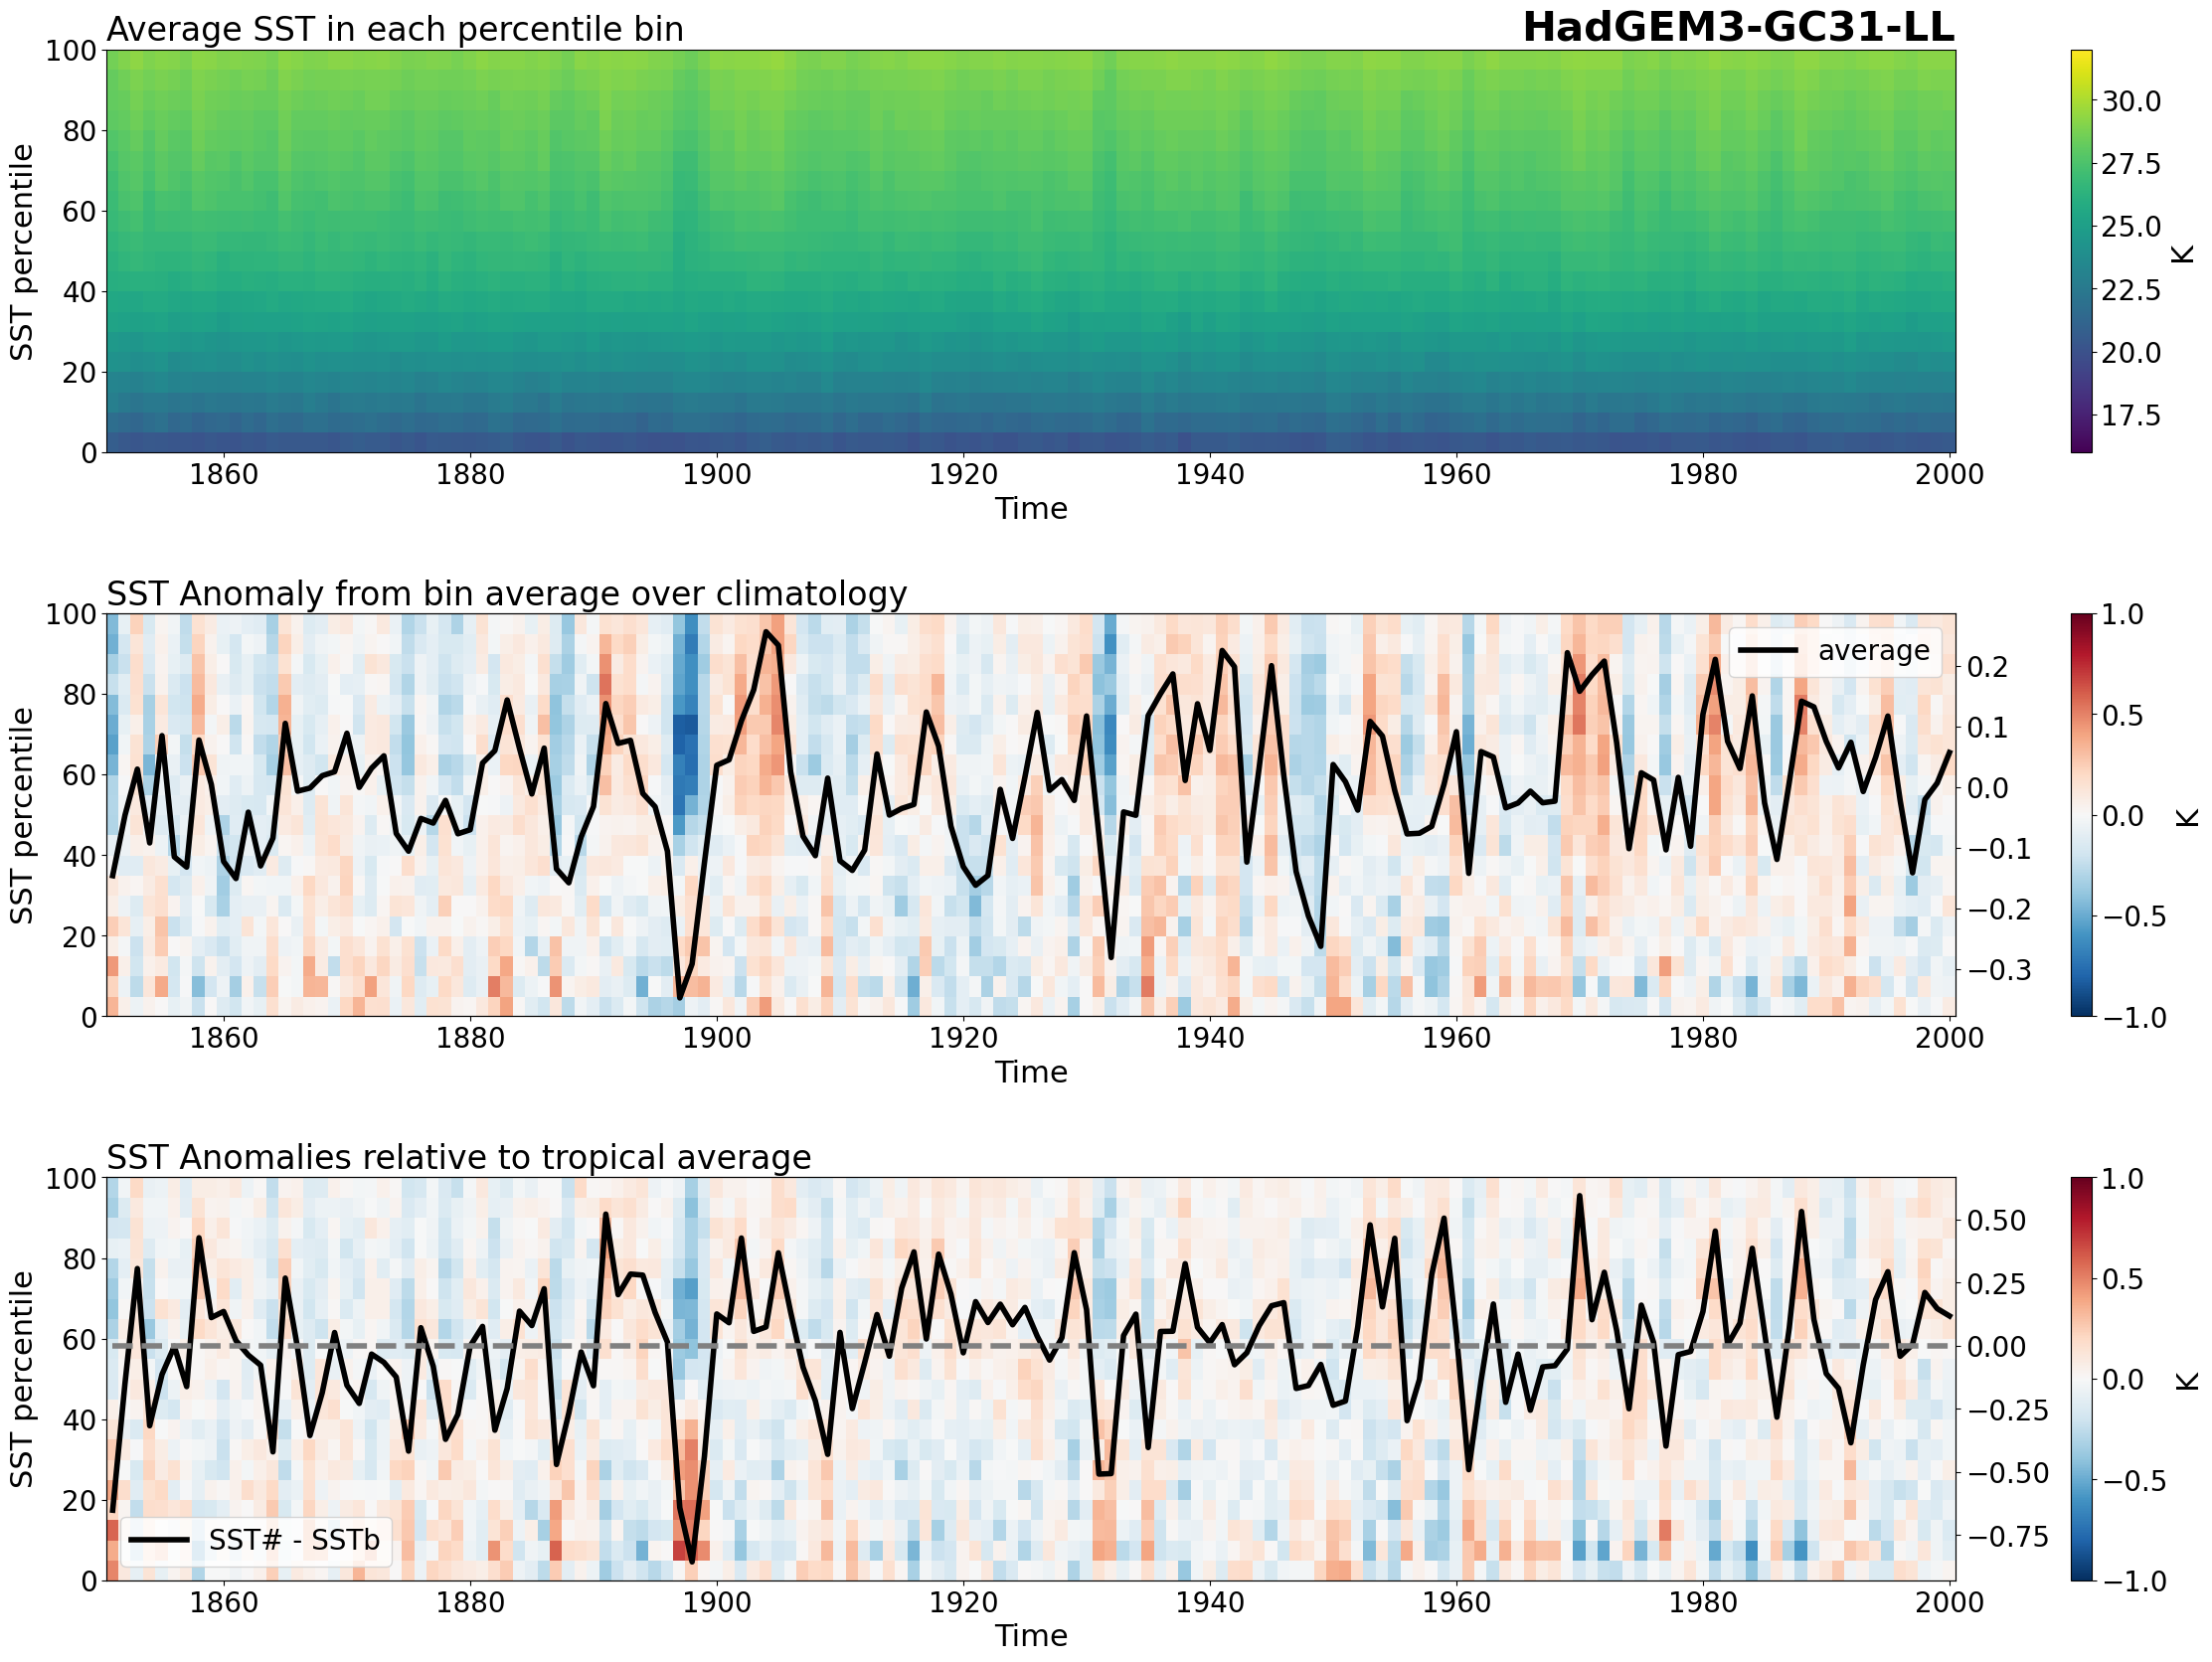

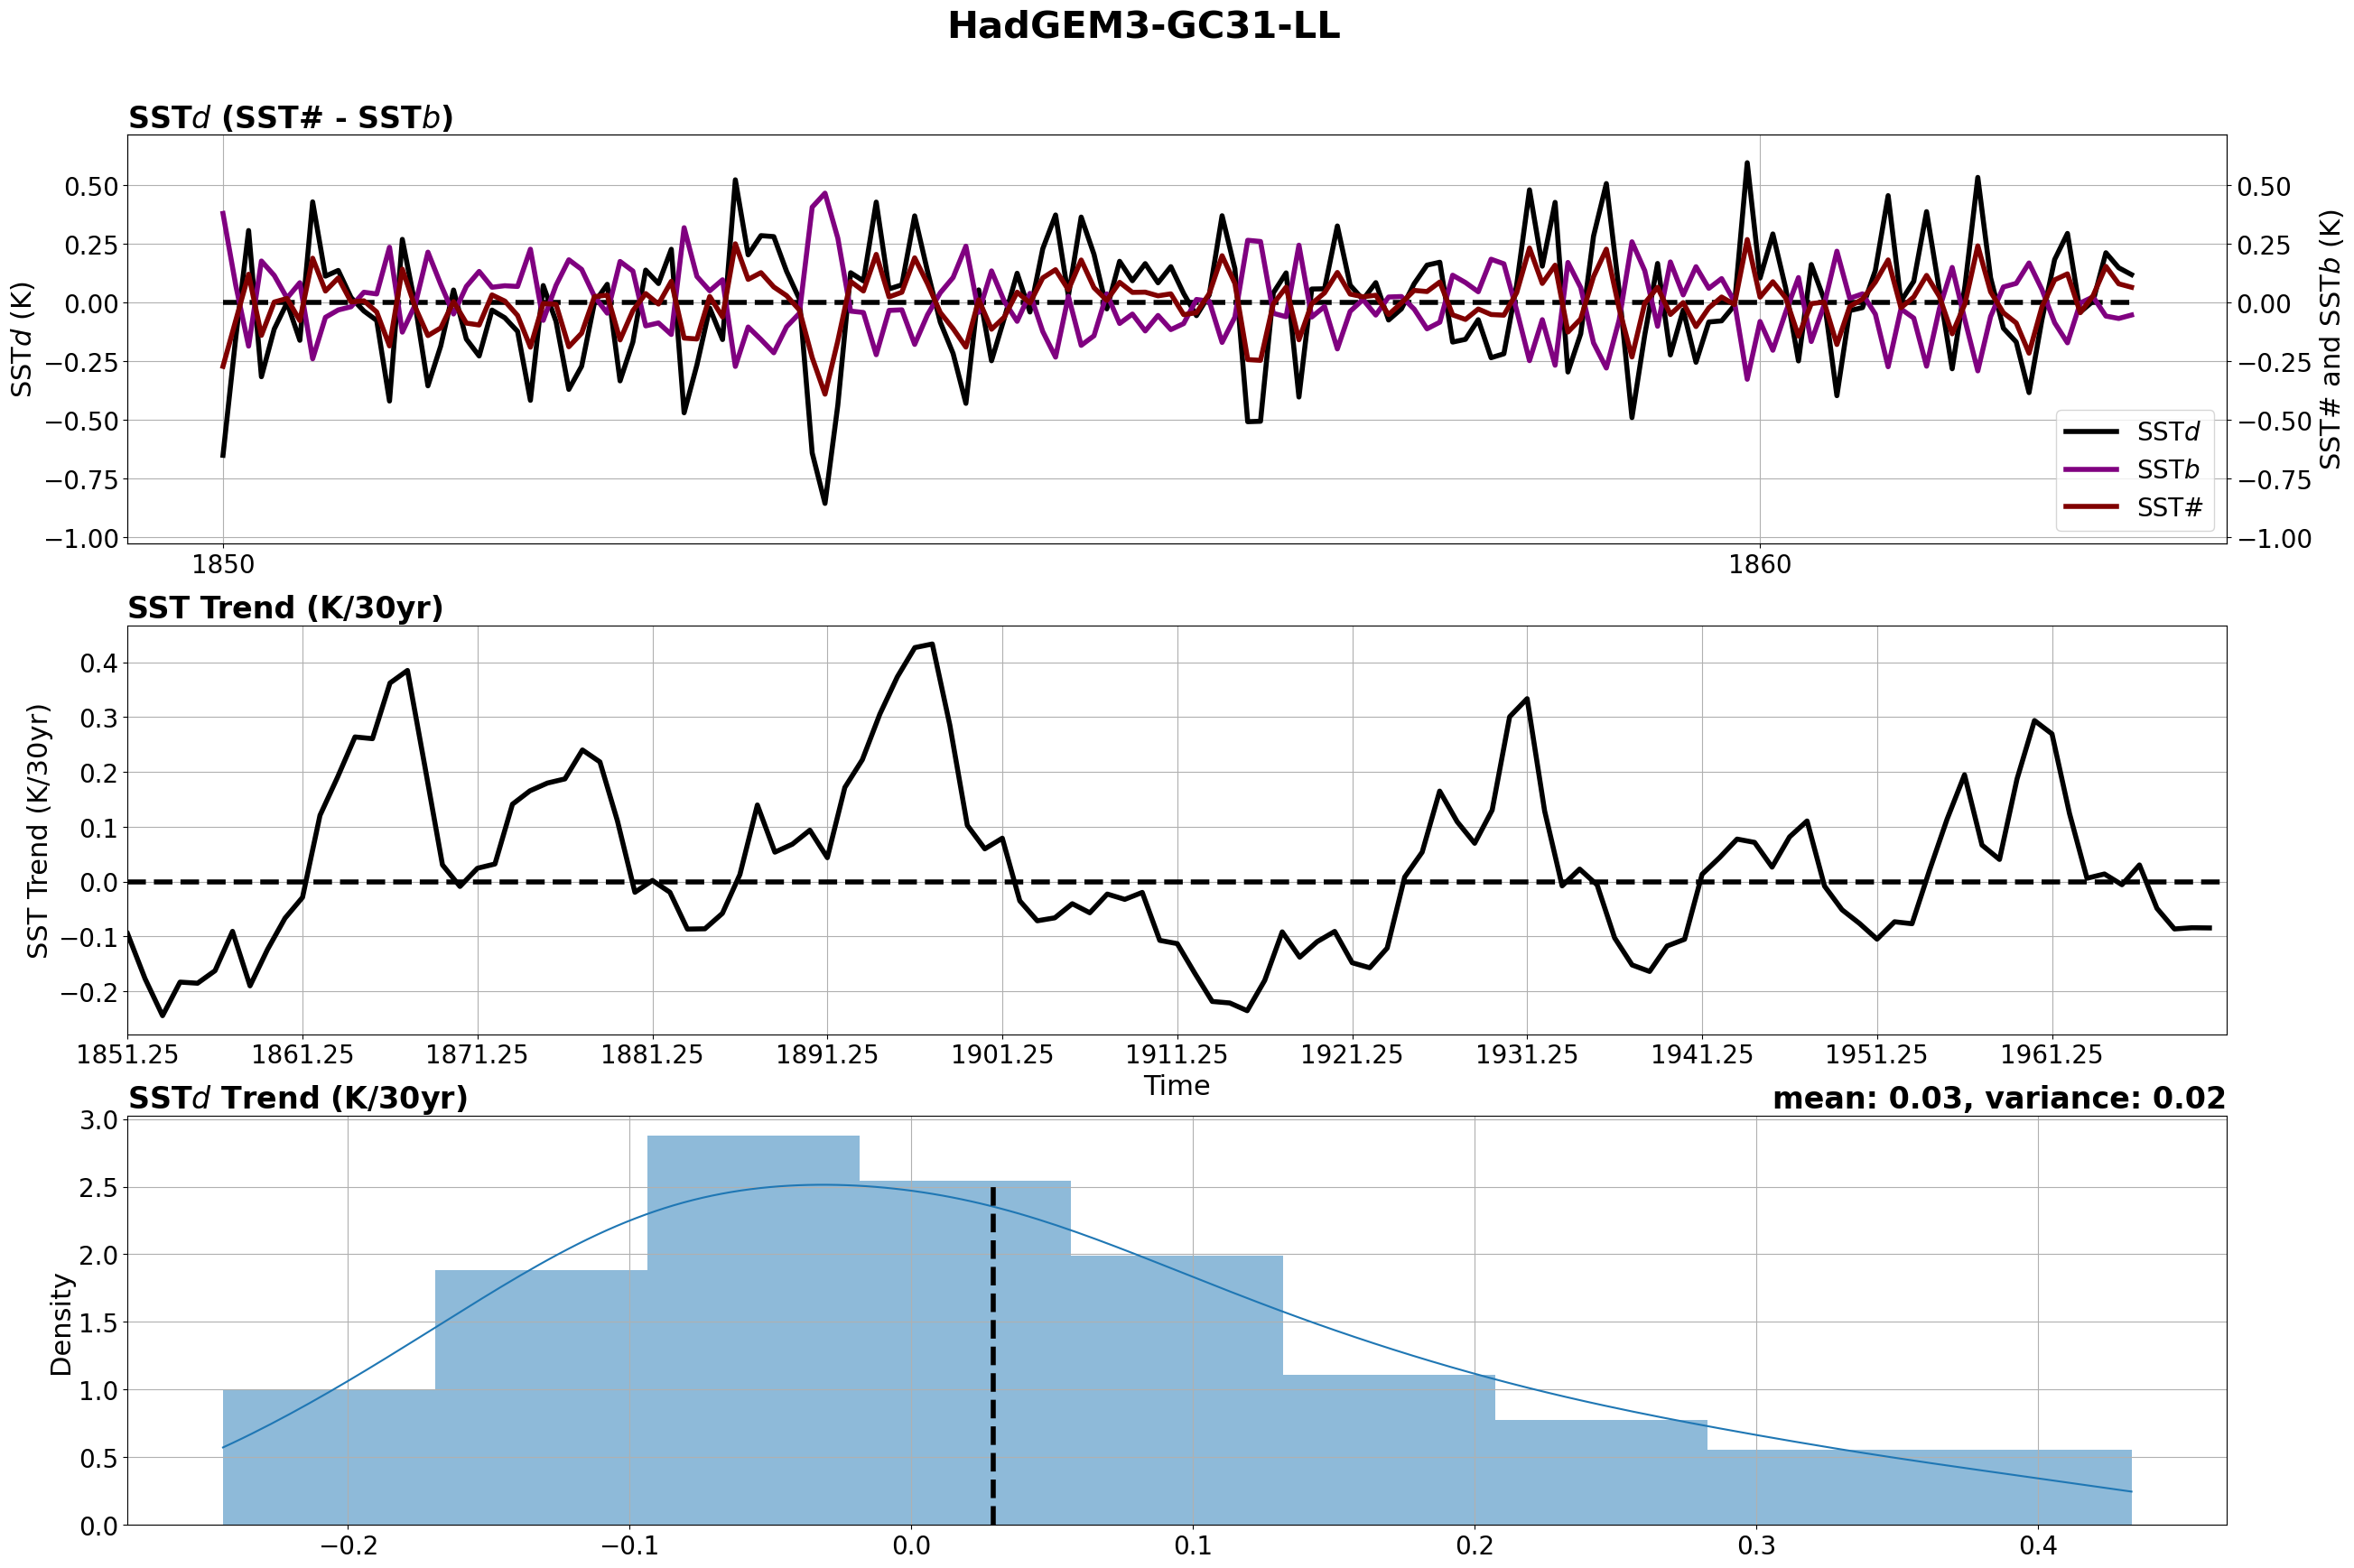

In [19]:
def calculate_SSTsharp(
    tos: xr.DataArray, 
    weights: xr.DataArray, 
    window: int = 12*30, 
    step: int = 12, 
    save: bool = False, 
    testing: bool = False
) -> xr.Dataset:
    """
    - Iterate over each model
    - Calculate SSTsharp package
    - Create sanity check figures
    - Save to netcdf

    Args:
        save (bool, optional): Save the SSTsharp package for each model. Defaults to False.
        testing (bool, optional): If testing, only do first model and 50 time steps. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing SSTsharp package for each model
    """
    models = tos.model.values
    ds = {}
    for model in models:
        print(f"Calculating SST sharpness for {model}")
        if testing:
            model = "HadGEM3-GC31-LL"

        try:
            if save: 
                # Calculate SSTsharp package
                ds_model = do_SSTsharp_sorting(
                    da=tos.sel(model=model), 
                    prctl_bins=prctl_bins, 
                    prctl_binmids=prctl_binmids, 
                    weights=weights
                )
                # Plot SSTsharp package
                create_percentile_figures(ds_model, model=model)

                # Calculate rolling trend of SSTd
                ds_model_trend = calculate_rolling_trend(ds_model, model=model, window=window, step=step)

                if save:
                    ds_model.to_netcdf(f"data/sharp/SSTsharp_{model}.nc")
                    ds_model_trend.to_netcdf(f"data/sharp/SSTsharp_{model}_trend.nc")

                ds[model] = ds_model

            else:
                print(f"Loading SST sharpness for {model}")
                ds[model] = xr.open_dataset(f"data/SSTsharp_{model}.nc", chunks="auto")

            if testing: 
                return ds

        except Exception as e:
            print(model, e)
        

    return ds

ds = calculate_SSTsharp(tos=tos_tropics, weights=weights_tropics, save=True, testing=True, step=1, window=30)


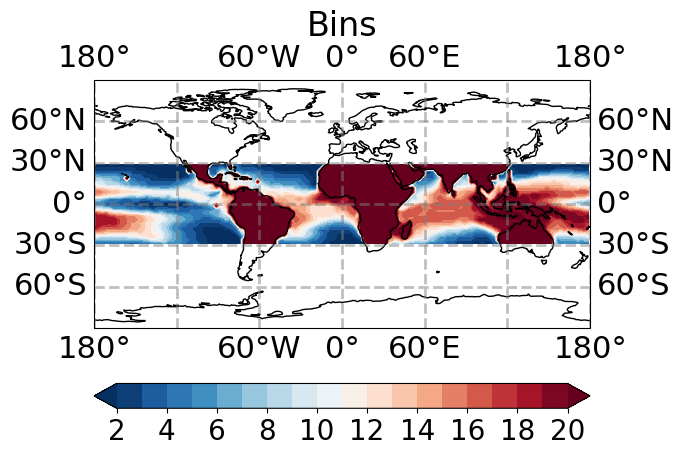

In [167]:
global_plot(ds["sortIdxs"].values.reshape((1800, 24, 144))[0,:,:], lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="Bins", levels=21) 

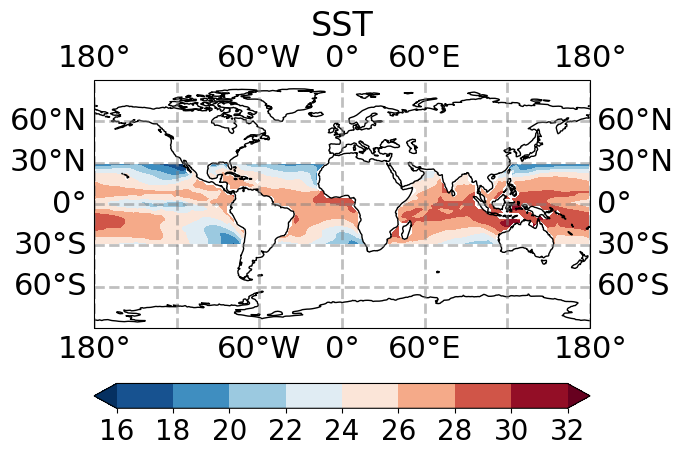

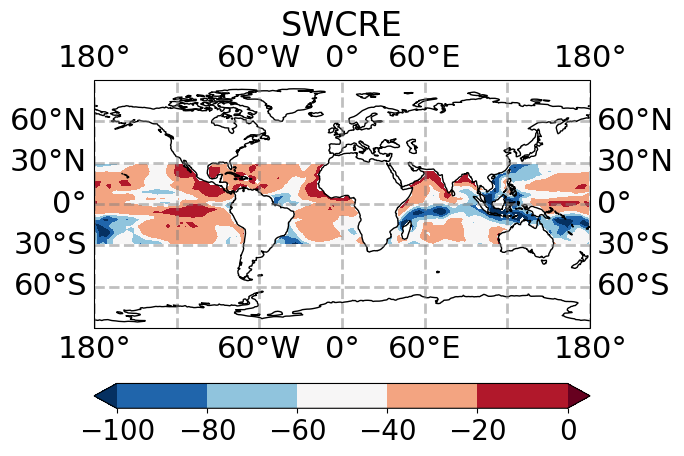

In [169]:
global_plot(tos_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SST", levels=8) #np.arange(16, 34, 2))
global_plot(swcre_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0), lat=tos_tropics.lat, lon=tos_tropics.lon, cmap="RdBu_r", title="SWCRE", levels=np.arange(-100, 20, 20)) #np.arange(-120, 45, 5))

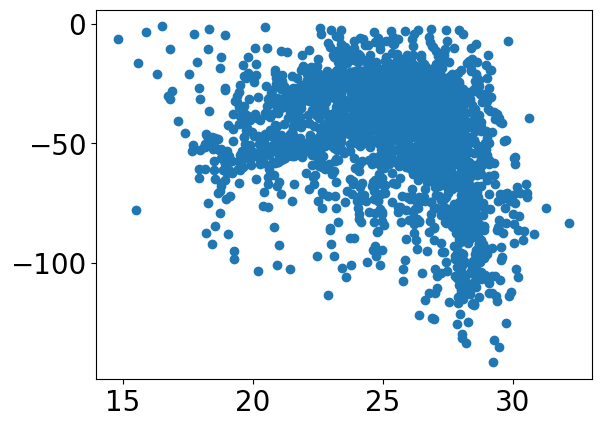

In [170]:
plt.scatter(tos_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0).values, swcre_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0))
# plt.scatter(tos_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0).values, swcre_tropics.sel(model="HadGEM3-GC31-LL").isel(time=0))

## Process SWCRE data

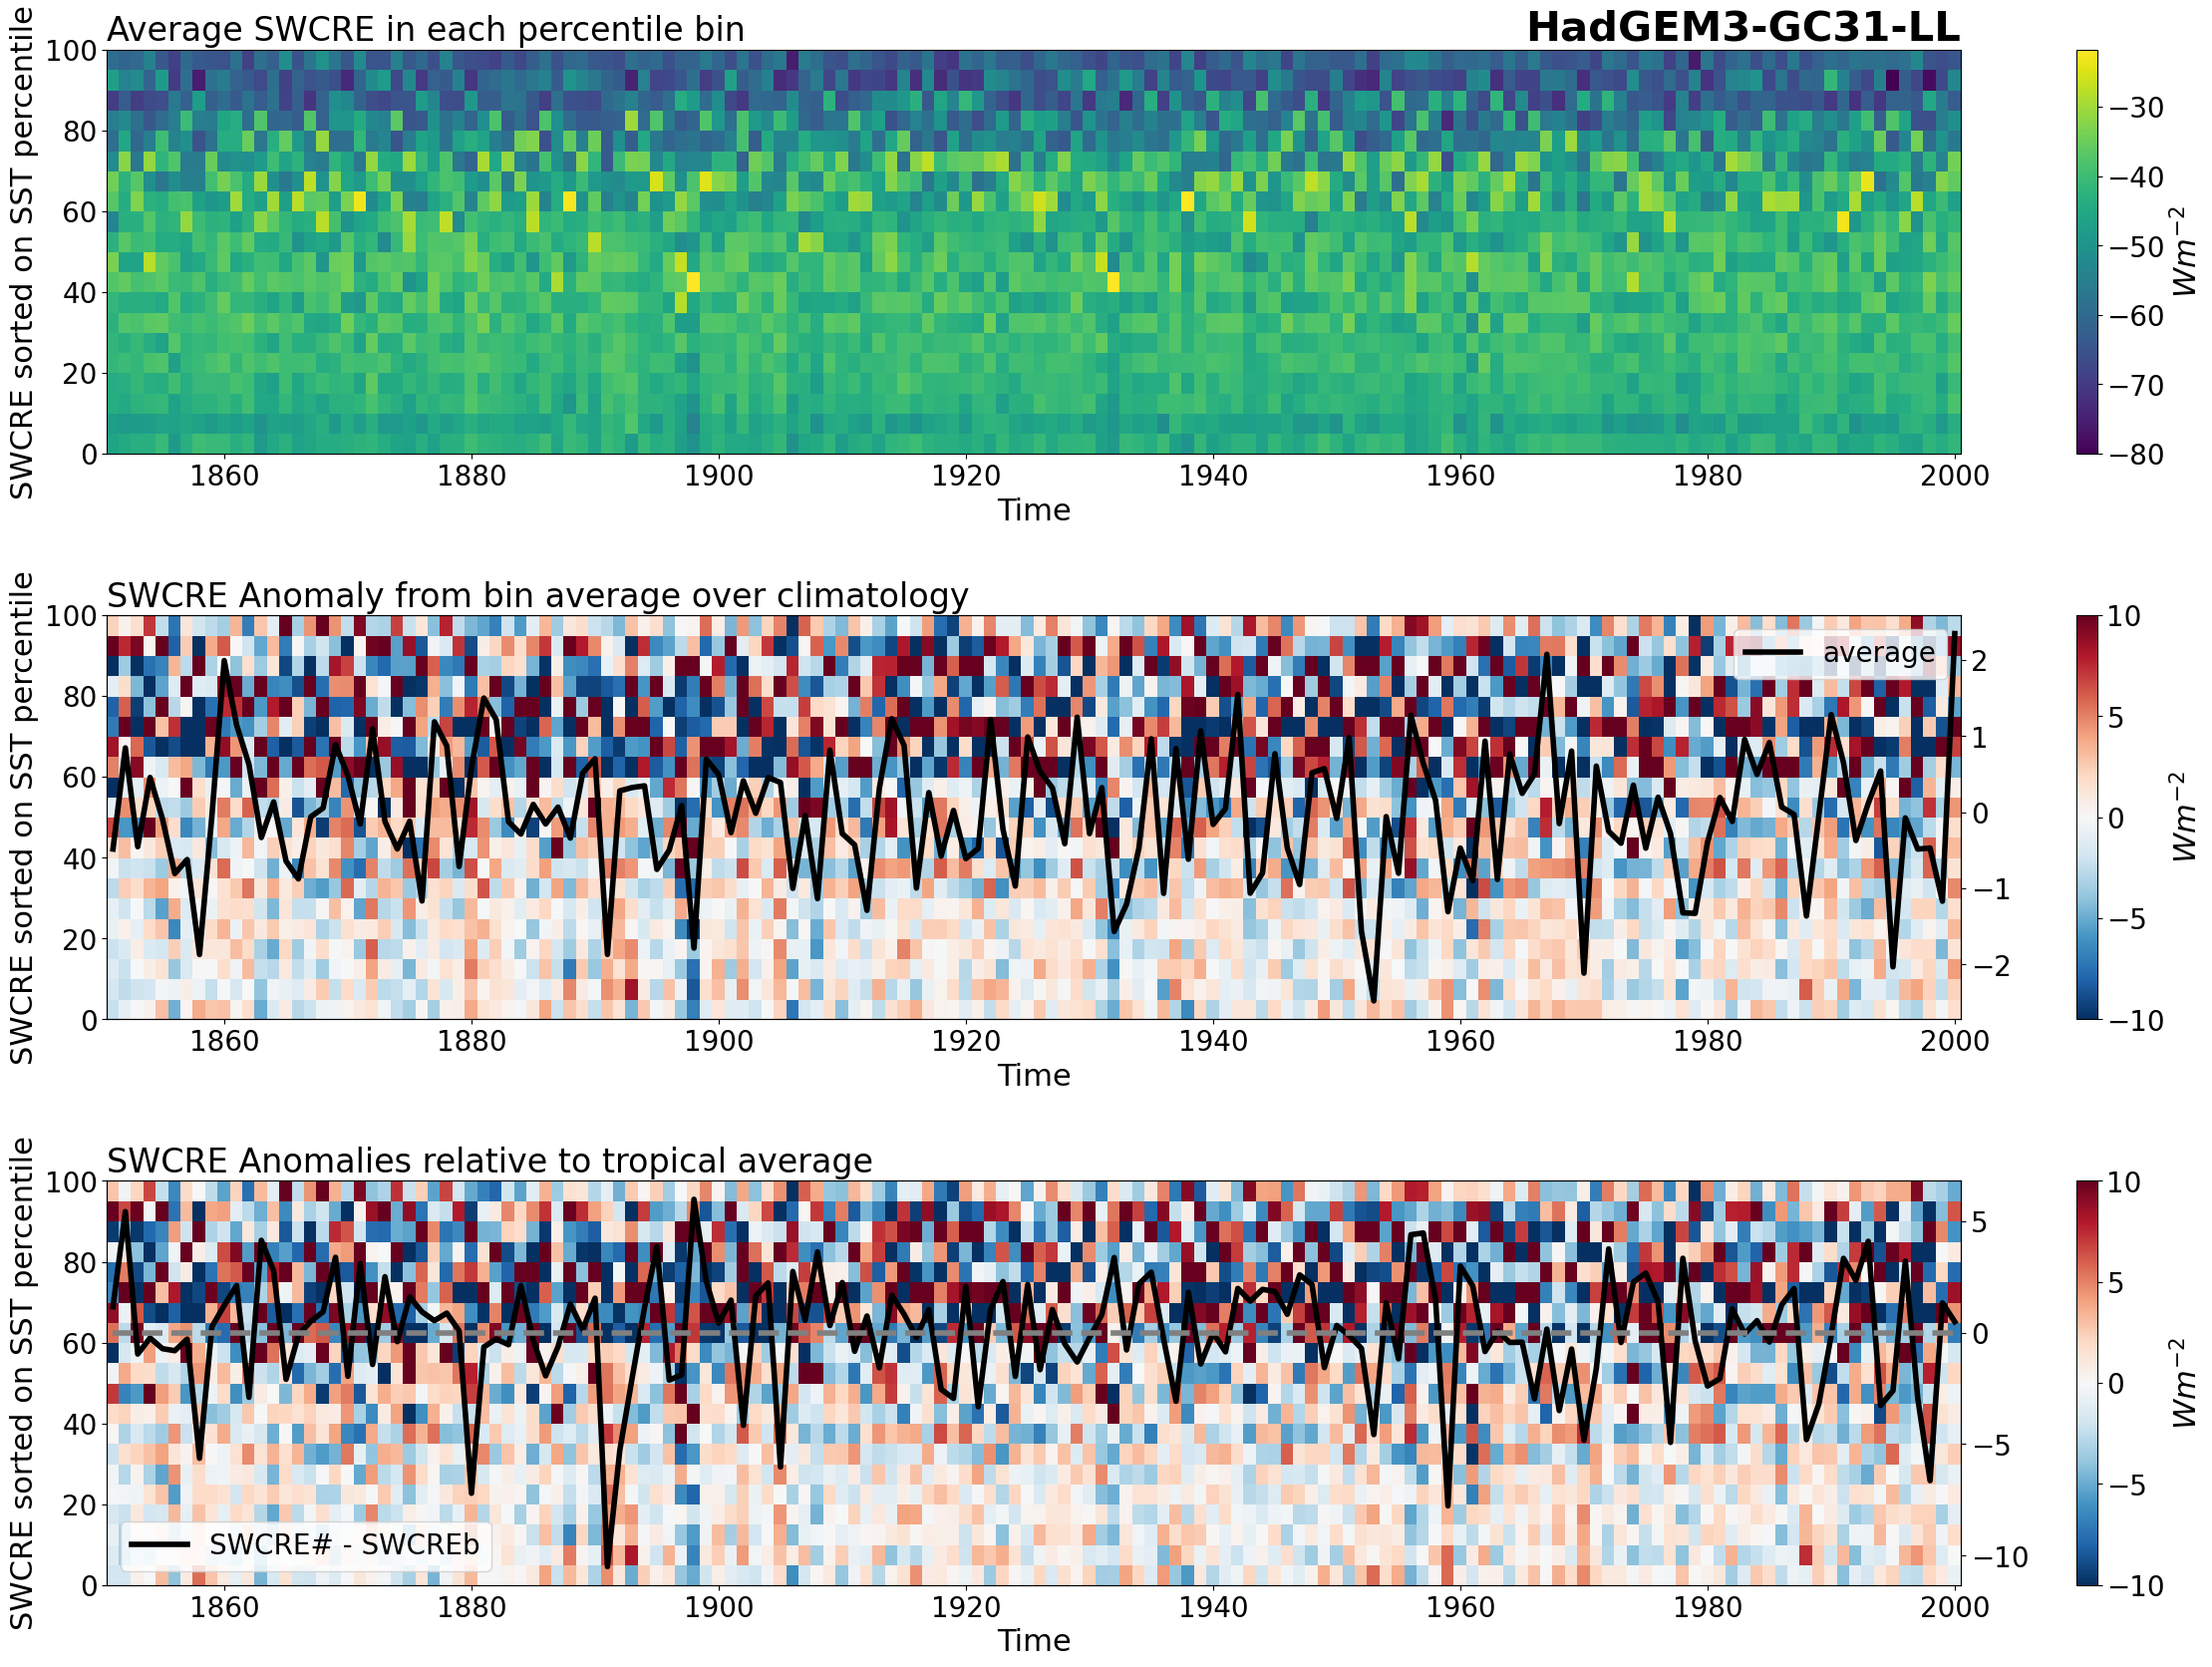

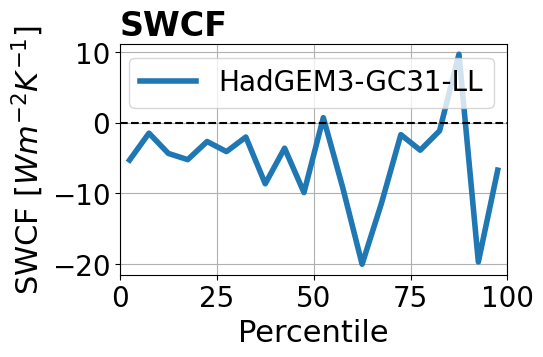

In [20]:
def calculate_SWCREsharp(
    swcre: xr.DataArray, 
    weights: xr.DataArray, 
    save: bool = False, 
    testing: bool = False
) -> xr.Dataset:
    """_summary_

    Args:
        save (bool, optional): _description_. Defaults to False.
        testing (bool, optional): _description_. Defaults to False.

    Returns:
        xr.Dataset: _description_
    """

    models = swcre.model.values
    swcre_sharp, swcf_sharp = {}, {}
    for model in models:
        if testing: 
            model = "HadGEM3-GC31-LL"

        try:
            if save:
                # Load SSTsharp package
                ds_sharp = xr.open_dataset(f"data/sharp/SSTsharp_{model}.nc")
                # Grab SWCRE model
                swcre_model = swcre.sel(model=model)

                # One-year low-pass filter 
                # swcre_model = swcre_model.resample(time="Y").mean()
                
                # Calculate SWCREsharp Package
                swcre_sharp[model] = apply_SSTsharp_to_SWCRE(
                    da=swcre_model,
                    ds_sharp=ds_sharp, 
                    prctl_bins=prctl_bins,
                    weights=weights,
                    model=model
                )
                # Create SWCRE figures
                create_swcre_percentile_figures(swcre_sharp[model], model=model)
                # Save SWCREsharp Package
                swcre_sharp[model].to_netcdf(f"data/sharp/SWCREsharp_{model}.nc")
                # Calculate SWCF
                swcf_sharp[model] = calculate_swcf_percentiles(SSTsharp=ds_sharp, SWCREsharp=swcre_sharp[model])
                # Calculate SWCF
                plot_swcf(swcf=swcf_sharp[model], model=model)
                # Save SWCF package
                swcf_sharp[model].to_netcdf(f"data/sharp/SWCF_{model}.nc")
                # Close SSTsharp package
                ds_sharp.close()
        
        except Exception as e:
            print(model, e)

        if testing:
            return swcre_sharp
   
    return swcre_sharp

swcre = calculate_SWCREsharp(swcre=swcre_tropics, weights=weights_tropics, save=True, testing=True)

# Analysis

In [102]:
swcf = {}
for model_path in glob("data/sharp/SWCF_*.nc"):
    model_name = model_path.split("/")[-1].split(".")[0][5:]
    swcf[model_name] = xr.open_dataset(model_path)["binanom_bar"]

ds = xr.concat(list(swcf.values()), dim='model')
# Set the coordinates for the 'model' dimension
ds_swcf = ds.assign_coords(model=list(swcf.keys()))

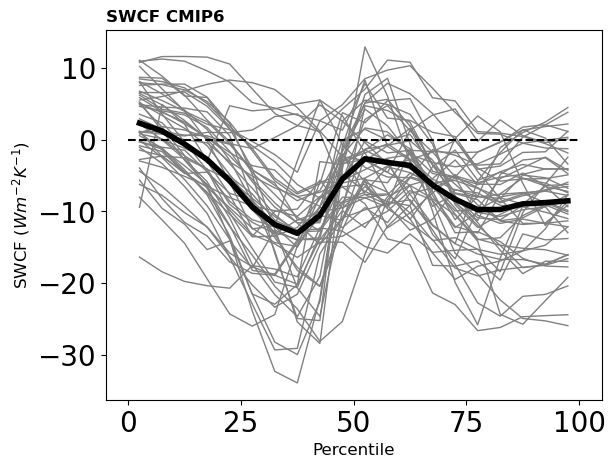

In [105]:
# Plot one line for each model 
ds_swcf.plot.line(x='bins', hue='model', add_legend=False, color="gray", linewidth=1)
ds_swcf.mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4)
plt.title("SWCF CMIP6", loc="left", fontweight="bold", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"SWCF ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

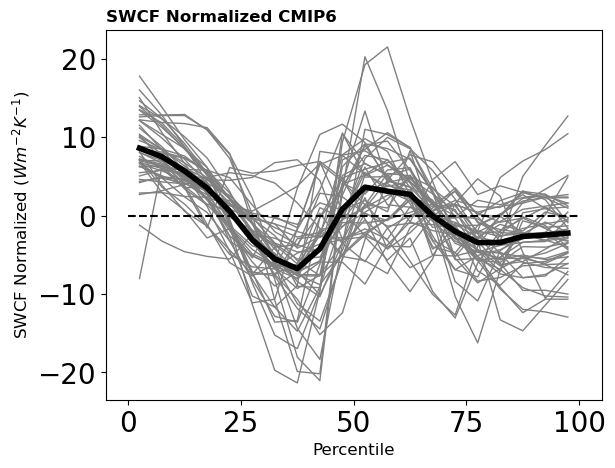

In [106]:
ds_swcf_normalized = ds_swcf - ds_swcf.mean(["bins"])
ds_swcf_normalized.plot.line(x='bins', hue='model', add_legend=False, color="gray", linewidth=1)
ds_swcf_normalized.mean(["model"]).plot.line(x='bins', add_legend=False, color="black", linewidth=4)
plt.title("SWCF Normalized CMIP6", loc="left", fontweight="bold", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel(r"SWCF Normalized ($Wm^{-2}K^{-1}$)", fontsize=12)
plt.hlines([0], xmin=0, xmax=100, linestyle="dashed", color="black")

In [107]:
def violin_plot_tos(tos, title):
    fig = plt.figure()
    sns.violinplot(data=tos, inner="quartile")
    plt.title(title + r" SST$_{W-E}$ Trend ($K/30yr$)")
    plt.grid()
    # Rotate the y-axis labels
    plt.tick_params(axis='x', labelrotation=90)
    fig.set_size_inches(20, 5)
    plt.xlabel("")
    plt.ylabel(r"SST$_{W-E}$ Trend ($K/30yr$)")

In [112]:
# Load trends
tos_trends = {}

for model in ds_swcf.model.values:
    tos_trends[model_name] = xr.open_dataarray(f"data/sharp/SSTsharp_{model}_trend.nc")["SSTd_trend"]
    print(tos_trends[model_name])
    break

ds_tos = xr.concat(list(tos_trends.values()), dim='model')
# Set the coordinates for the 'model' dimension
ds_tos = ds.assign_coords(model=list(ds_swcf.model.values))

ValueError: Given file dataset contains more than one data variable. Please read with xarray.open_dataset and then select the variable you want.